# Simultaneous Imitation

## Abstract
TODO


## Imitation Task
This is the video, subjects saw the video and imitated movements **simultaneously**.
<iframe width="560" height="315" src="https://www.youtube.com/embed/2hhV0Ev2PDQ"></iframe>


## Subject heatmap and Grand Average

We calculate the grand average data heatmap for fixation, data ranges are [0, 48] and [0, 30] for 
(x, y) respectively so we need to filter data as the next scatter plot shows.


97.96991508986682% of data inside this range


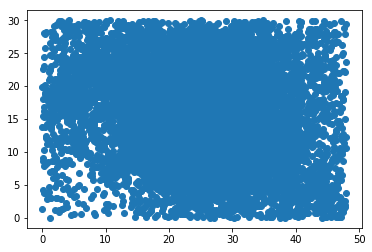

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('./source_data/data.csv')

x0 = data['x_start']  # index = 2
y0 = data['y_start']  # index = 3

mask = [(x > 0) and (x < 48) and (y > 0) and (y < 30) for x, y in zip(x0, y0)]
print("{}% of data inside this range".format(100*sum(mask)/len(mask)))
plt.scatter(x0[mask], y0[mask])
plt.show()


## Creating a trial-only mask and modify x-y coordinates
From all data points we need to use only those points inside useful trial intervals so we need to mask them, we also
modify x-y coords that were normalized by 48, 30


In [9]:
import pandas as pd
import numpy as np


data = pd.read_csv('./source_data/data.csv')
t0 = data['time_start'].as_matrix()
subject = data['subject'].as_matrix() - 1  # subject1 is 0 in python

trial_data = pd.read_excel('./source_data/Frames.xlsx')
ids = trial_data['id'].as_matrix()

# mark trials 1 to 5 with that number, passive observation as 0, -1 everything else
# take out the invalid subjects, marked with 0 as id
mask = [i for i in range(len(ids)) if ids[i] > 0]

# transform frame tags to time, videos were at 30fps
intervals = [(trial_data['passivei'].as_matrix()[mask]/30, trial_data['passivef'].as_matrix()[mask]/30), 
             (trial_data['t1i'].as_matrix()[mask]/30, trial_data['t1f'].as_matrix()[mask]/30), 
             (trial_data['t2i'].as_matrix()[mask]/30, trial_data['t2f'].as_matrix()[mask]/30), 
             (trial_data['t3i'].as_matrix()[mask]/30, trial_data['t3f'].as_matrix()[mask]/30), 
             (trial_data['t4i'].as_matrix()[mask]/30, trial_data['t4f'].as_matrix()[mask]/30), 
             (trial_data['t5i'].as_matrix()[mask]/30, trial_data['t5f'].as_matrix()[mask]/30)]

trial_id = np.zeros(t0.shape) - 1
for data_index in range(len(trial_id)):
    for tuple_index in range(len(intervals)):
        interval_low = intervals[tuple_index][0]
        interval_high = intervals[tuple_index][1]
        low = interval_low[subject[data_index]]
        high = interval_high[subject[data_index]]
        
        if low < t0[data_index] < high:
            trial_id[data_index] = tuple_index
            
# add this mask to data csv
data['trial_id'] = trial_id

# calculate percentage of data outside of a trial
ratio = np.sum(trial_id == -1) / len(trial_id) 
print("{}% of Data outside of trials".format(ratio*100))

# make a modified file
data.to_csv('./source_data/data_modified.csv')


/home/babybrain/PycharmProjects/accelerometer-data/venv/lib/python3.5/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/home/babybrain/PycharmProjects/accelerometer-data/venv/lib/python3.5/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/babybrain/PycharmProjects/accelerometer-data/venv/lib/python3.5/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/home/babybrain/PycharmProjects/accelerometer-data/venv/lib/python3.5/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/babybrain/PycharmProjects/accelerometer-data/venv/lib/python3.5/site-packages/ipykernel_launcher.py:19: FutureWarning:

74.20369811646049% of Data outside of trials


Taking this in mind we resize data to real monitor setting and we create the heatmap:


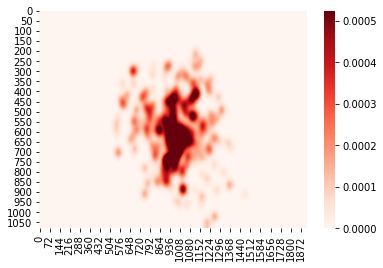

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import cv2


# import data
data = pd.read_csv('./source_data/data_modified.csv')
x0_resized = data['x_start']*1920/48
y0_resized = data['y_start']*1080/30
data_type = data['type']
trial_id = data['trial_id']

duration = data['duration']

# creating mask to subset data: tag = 1,2,3 - sacc,fix,sp; t_id = 0 to 5 according to trial id (0 is passive obs)
mask = [(x > 0) and (x < 1920) and (y > 0) and (y < 1080) and tag == 2 and t_id == 1 for x, y, tag, t_id in 
        zip(x0_resized, y0_resized, data_type, trial_id)]

# translate to a heatmap
heatmap = np.zeros((1080, 1920))
for x, y, t, valid in zip(x0_resized, y0_resized, duration, mask):
    if valid:
        heatmap[int(y), int(x)] = t

# gaussian filter heatmap
blurred_heatmap = cv2.GaussianBlur(heatmap, (0, 0), 20)

sb.heatmap(blurred_heatmap, cmap='Reds', robust=True)
plt.show()


## Fixation/Saccade/SmoothPursuit Characterization Overview

We calculate mean fixation duration and number as grand-average.


Grand average fix 0.35375081353631066
Grand average sacc 0.05851383952482124
Grand average smooth 0.9650315557224927


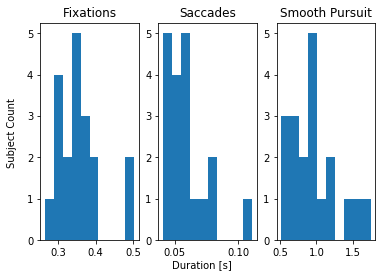

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# create a function that averages duration per subject
def group_average_duration(dataframe, event_id):
    times = dataframe['duration']
    subject_mask = dataframe['subject']
    type_mask = dataframe['type'] 
    trial_mask = dataframe['trial_id']
    n_subjects = subject_mask.max()
    mean_data = np.empty(n_subjects)
    
    for n in range(n_subjects):
        subject_data = [time for index, time in enumerate(times) 
                        if subject_mask[index] == n+1 and type_mask[index] == event_id and trial_mask[index] >= 0]
        mean_data[n] = np.nanmean(subject_data)  # change to use np.nanmean() for duration or len() for quantity
    return mean_data


# import data
data = pd.read_csv('./source_data/data_modified.csv')

# average events
data_type = dict(sacc=1, fix=2, smp=3)  # smp = smooth pursuit
sacc_duration = group_average_duration(data, data_type['sacc'])
fix_duration = group_average_duration(data, data_type['fix'])
smp_duration = group_average_duration(data, data_type['smp'])


print("Grand average fix {}".format(np.nanmean(fix_duration)))
print("Grand average sacc {}".format(np.nanmean(sacc_duration)))
print("Grand average smooth {}".format(np.nanmean(smp_duration)))

# plot average duration for subjects histogram
fig, axes = plt.subplots(1, 3)
axes[0].hist(fix_duration)
axes[0].set_title("Fixations")
axes[1].hist(sacc_duration)
axes[1].set_title("Saccades")
axes[2].hist(smp_duration)
axes[2].set_title("Smooth Pursuit")

# Set common labels
fig.text(0.5, 0.04, 'Duration [s]', ha='center', va='center')
fig.text(0.06, 0.5, 'Subject Count', ha='center', va='center', rotation='vertical')

plt.savefig("average_durations.png", dpi=1000)
plt.show()

## Calculate Fix-Sacc-SmoothP per Trial


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Quantity   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     2.722
Date:                Mon, 01 Jul 2019   Prob (F-statistic):             0.0231
Time:                        18:01:29   Log-Likelihood:                -323.71
No. Observations:                 120   AIC:                             659.4
Df Residuals:                     114   BIC:                             676.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.3500      0.824      6.493      0.000       3.718       6.982
C(Trial)[T.1]     2.4000      1.165      2.059      0.042       0.091       4.709
C(Trial)[T.2]     3.6000      1.165      3.089      0.003       1.291       5.909
C(Trial)[T.3]     3.1000      1.165      2.660      0.009       0.791       5.409
C(Trial)[T.4]     3.3500      1.165      2.875      0.005       1.041       5.659
C(Trial)[T.5]     3.4000      1.165      2.918      0.004       1.091       5.709
==============================================================================
Omnibus:                        2.733   Durbin-Watson:                   1.638
Prob(Omnibus):                  0.255   Jarque-Bera (JB):                2.614
Skew:                          -0.359   Prob(JB):                        0.271
Kurtosis:                       2.915   Cond. No.                         6.85
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

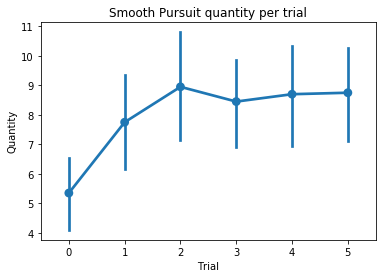

In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
# import statsmodels.api as sm
from statsmodels.formula.api import ols


# import data
data = pd.read_csv('./source_data/data_modified.csv')
data_type = data['type']
trial_id = data['trial_id']
duration = data['duration']
subject_id = data['subject']

data_list = []  # save subject, trial, duration
for trial in range(6):
    for subject in range(20):
        # tag: 1 - sacc; 2 - fix; 3 - sp
        sub_times = [a_time for a_time, sub, tag, t_id in zip(duration, subject_id, data_type, trial_id)
                 if sub == subject and tag == 3 and t_id == trial]
        data_list.append([subject, trial, len(sub_times)])  # append np.nanmean or len for duration/quantity

# summarize into a dataframe
grand_averages = pd.DataFrame(data_list, columns=["Subject", "Trial", "Quantity"])
point_plot = \
    sns.pointplot(x="Trial", y="Quantity", data = grand_averages).set_title("Smooth Pursuit quantity per trial")
fig = point_plot.get_figure()
fig.savefig("sp_quantity_trials.png", dpi=1000)

# apply ANOVA for significance
anova = ols('Quantity ~ C(Trial)', data=grand_averages).fit()
anova.summary()
# aov_table = sm.stats.anova_lm(anova, typ=2)
# aov_table


## Cut acc signal according to trials frames (checkout if matlab was done right)


In [13]:
# TODO: Make a function that cuts signal according to frames in trial, remember that acc signal is in time, 
# we need TTL = when acc was ON in frame
print("!")


!


## Calculate Performance Using MSE
We calculate performance MSE in 4 sensors (per subject, per trial, grand average)


In [14]:
# TODO


## Calculate Gaze-time per zone


In [15]:
# TODO

